## <center>HW4 - Business Data Science (MIS382N)</center>
### <center>Submitted by Prajval Gupta and Subhayu Chakravarty</center>


### Problem 1 – Warm up. Grid Search CV.

1.  Run  this  simple  example  from  scikit  learn,  and  understand  what  each  command  is  doing:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [24]:
#Import Statements
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
sns.set(style='ticks', palette='Set2')
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import warnings
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [103]:
print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model 

#### Hyperparameters are being tuned for SVC model using GridSearch Cross-validation.

<br>

### Problem 2: Lasso, Forward Selection and Cross Validation

Use the data generation used in the Lecture 7 notebook, where we first introduced Lasso, to generate data.

1. Manually implement forward selection. Report the order in which you add features.

2. Plot test error as a function of the size of the support. Can you use this to recover the true support?

3. Use Lasso with a manually implemented Cross validation using the metric of your choice. What is the value of the hyperparameter? (Manually implemented means that you can either do it entirely on your own, or you can use GridSearchCV, but I’m asking you not to use LassoCV, which you will use in the next problem).

4. Change the number of folds in your CV and repeat the previous step. How does the optimal value of the hyperparameter change? Try to explain any trends that you find.

5. Read about and use LassoCV from sklearn.linear model. How does this compare with what you did in the previous step? If they agree, then explain why they agree, and if they disagree explain why. This will require you to make sure you understand what LassoCV is doing.

In [14]:
# Generating some sparse data to play with
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generation with k nonzeros
# coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Splitting data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:80], y[:80]
X_test, y_test = X[80:], y[80:]

#### 1. Forward Selection of Features on the basis of R2_Score and applying Ordinary Least Squares model

In [15]:
total_features=200
OLS = LinearRegression()
feat_select_order = []
test_error=[]

# Taking n features
n=5

for feature_num in range(n):

    score = np.zeros(total_features)
    for current in range(total_features):
        if current not in feat_select_order:
            OLS.fit(X[:, feat_select_order+[current]], y)
            score[current] = r2_score(y, OLS.predict(X[:, feat_select_order+[current]])) 
#     ypred=OLS.predict(X)
    test_error.append(1-score[current])
    feat_select_order.append(np.where(score == np.amax(score))[0][0])

print("Feature Selection order for {} features : ".format(n))
print(feat_select_order)

Feature Selection order for 5 features : 
[18, 15, 51, 78, 34]


In [16]:
# The true coefficients
np.where(coef != 0)

(array([15, 18, 34, 51, 78]),)

#### 2. Plot of error as function of size of support

Feature Coefficients: [18, 15, 51, 78, 34]


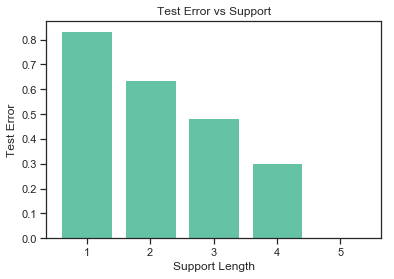

In [17]:
# Finding test error - mean squared error for Feature selection using SFS selector
sfs_selector = sfs(LinearRegression(), k_features=5, forward=True, scoring='r2')
sfs_selector = sfs_selector.fit(X, y)

print('Feature Coefficients: {}'.format(feat_select_order))

# Plotting Test error for selected features
support = [len(sfs_selector.subsets_[i]['feature_names']) for i in sfs_selector.subsets_.keys()]
sfs_test_errors = [(1 - sfs_selector.subsets_[i]['avg_score']) for i in sfs_selector.subsets_.keys()]

plt.bar(support, sfs_test_errors)
plt.title('Test Error vs Support')
plt.ylabel('Test Error')
plt.xlabel('Support Length')
plt.show()

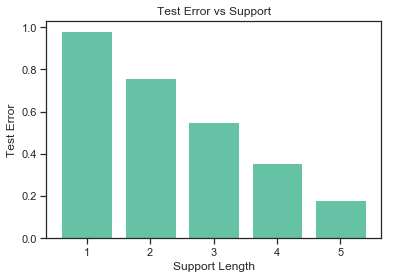

In [18]:
# Plot of error from manual forward selection
plt.bar(support, test_error)
plt.title('Test Error vs Support')
plt.ylabel('Test Error')
plt.xlabel('Support Length')
plt.show()

#### True support is when error becomes minimum, i.e at 5 features.

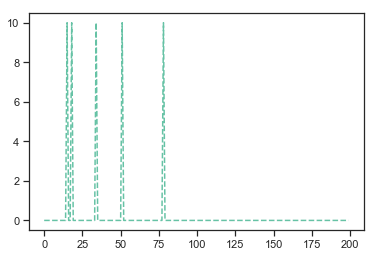

In [19]:
# Plot of original coefficients - 5 features
plt.plot(coef, '--', label='original coefficients')
plt.show()

#### 3. GridSearch Cross-validation of Lasso

In [25]:
import warnings
warnings.filterwarnings("ignore")
lm = make_pipeline(Lasso(random_state=7))
alphas = { 
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
}

clf = GridSearchCV(lm, alphas, cv=5)
clf.fit(X_train, y_train)
print('Best score:', clf.best_score_)
print('The best alpha : {}'.format(clf.best_params_['lasso__alpha']))

Best score: 0.9999982029975101
The best alpha : 0.01


#### 4. Changing Folds in Cross Validation

In [392]:
warnings.filterwarnings("ignore")
kfolds=[5, 10, 15, 20, 25]

for fold in kfolds:
    lm = make_pipeline(Lasso(random_state=7))
    alphas = { 
        'lasso__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
    }

    clf = GridSearchCV(lm, alphas, cv=fold)
    clf.fit(X_train, y_train)
    print()
    print('Best score for k = {} : '.format(fold), clf.best_score_)
    print('The best alpha : {} '.format(clf.best_params_['lasso__alpha']))


Best score for k = 5 :  0.9999982029975101
The best alpha : 0.01 

Best score for k = 10 :  0.9999981563365743
The best alpha : 0.01 

Best score for k = 15 :  0.9999981514474008
The best alpha : 0.01 

Best score for k = 20 :  0.9999966821445652
The best alpha : 0.01 

Best score for k = 25 :  0.9999946982097031
The best alpha : 0.01 


#### No change in optimal alpha when varying number of folds as the scores do not change by much. But we can observe a trend on changing alpha.

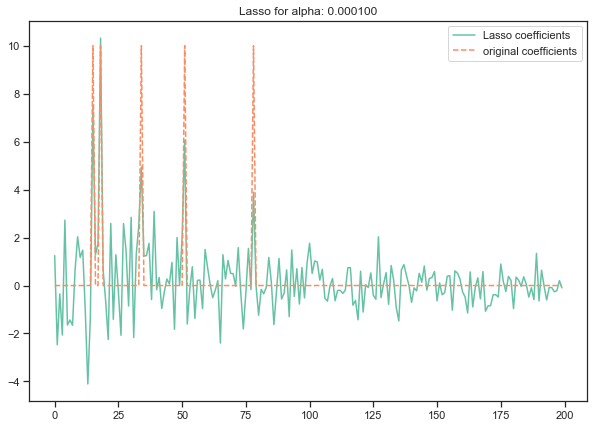

R2 Score:  -0.13130280803396843




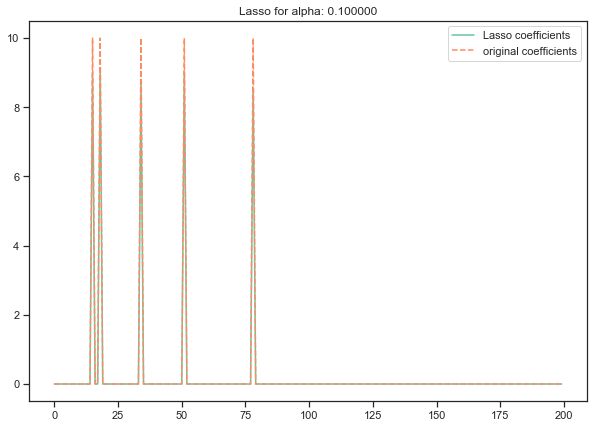

R2 Score:  0.9813451417214629


In [396]:
alpha = 1e-4
lasso = Lasso(alpha=alpha)

y_pred = lasso.fit(X_train, y_train).predict(X_test)

plt.figure(figsize=(10,7))
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso for alpha: %f"%alpha)
plt.show()

print("R2 Score: ",r2_score(y_test, y_pred))
print()
print()
alpha = 0.1
lasso = Lasso(alpha=1)

y_pred = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred)
plt.figure(figsize=(10,7))
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso for alpha: %f"%alpha)
plt.show()

print("R2 Score: ",r2_score(y_test, y_pred))

#### For small alpha, Lasso has taken most/all of the features and the general trend on alpha is that as it reaches optimal alpha with the best score the number of features reduces.

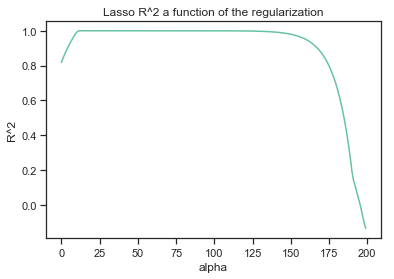

In [402]:
r_sq = []
coefs = []
alphas = np.logspace(-3, 1, 200)
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
    r2_score_lasso = r2_score(y_test, y_pred_lasso)
    r_sq.append(r2_score_lasso)

plt.plot(r_sq)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.title('Lasso R^2 a function of the regularization')
plt.show()

#### Here we can observe the trend of R2 score for different alpha values.

#### 5. Lasso CV

In [397]:
from sklearn.linear_model import LassoCV

lcv = LassoCV(cv=10, random_state=123)
lcv.fit(X_train, y_train)

print('Best score: {}'.format(lcv.score(X_train, y_train)))
print('The Best alpha by LassoCV: {}'.format(round(lcv.alpha_,2)))

Best score: 0.9999986020329154
The Best alpha by LassoCV: 0.01


#### The optimal alpha obtained through LassoCV is the same as obtained through applying GridSearchCV the only difference is that LassoCV iterated through many values of alpha on its own and arrived at this best alpha instead of us passing it.

<br>

### Problem 3: Theory of Communication

Read Shannon’s 1948 paper ’A Mathematical Theory of Communication’. 
Focus on pages 1-19 (up to Part II), the remaining part is more relevant for communication. http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf 

Summarize what you learned briefly (e.g. half a page).


The research paper begins by referring to the progress made in modulation (Pulse-position and Pulse-code modulation) and states the objective of this theory. The objective is primarily to extend previous theories, include new factors like noise in channel and use statistics on the message and destination to realize minimize loss. The author also states how the logarithm is the "most natural choice" as a measure of information contained in the messages due to following factors:
	1. It is realistic as many real-life processes and features vary logarithmically.
	2. It is intuitive to our understanding.
	3. It is simpler mathematically when taking limits.

Next, after labelling the various components of a communication system, the paper talks about discrete noiseless channels stating examples of the telegraph and teletype, explaining the corresponding signals used in each case. Capacity is defined in terms of the number of allowed signals(N) of duration(T) and there are details of restrictions placed on channels in terms of allowable sequences. 

The author then describes sources of information in a mathematical fashion by the proper encoding of information. For example how each letter in English have different probabilities of appearing in a message, this can be factored in to encode the information in messages. The author talks about zero, first, second and third and offers an example of the process to reach a level resembling spoken English from just letters in a stochastic process called Markoff.

The most crucial lesson that we learnt from the paper comes next, which is a primer on Entropy. The formula, how it came into picture and more importantly the significance of this concept in statistics. It is not just a measure of randomness(the Physics version of the concept) but in statistics this translates to uncertainty. It is how much further we are from knowing the exact outcomes. It can also be realized as how much choice we have in its selection. This was extremely useful in the Problem 4, where we measured entropy of a random word and realized it is ultimately the uncertainty of finding that word in a paper.



#### Problem 4 done in the end.

### Problem 5: Logistic Regression

The following is a logistic regression problem using a real data set, made available by the authors
of the book “Applied Regression and Muiltilevel Modeling” by Gelman and Hill.
Download the data from the book, which you can find here http://www.stat.columbia.edu/ ~gelman/arm/software/. In particular, we are interested in the arsenic data set. The file wells.dat contains data on 3,020 households in Bangladesh. For each family, the natural ar- senic level of each well was measured. In addition, the distance to the nearest safest well was measured. Each family is also described by a feature that relates to their community involvement, and a feature that gives the education level of the head of household. We are interested in building a model that predicts whether the family decided to switch wells or not, based on being informed of the level of arsenic in the well. Thus the “label” for this problem is the binary vector that is the
first column of the dataset, labeled “switch.”

• Fit a logistic regression model using only an offset term and the distance to the nearest safe well.

• Plot your answer: that is, plot the probability of switching wells as a function of the distance to the nearest safe well.

• Interpreting logistic regression coefficients: Use the “rule-of-4” discussed in class on Thursday, to interpret the solution: what can you say about the change in the probability of switching wells, for every additional 100 meters of distance?

• Now solve a logistic regression incorporating the constant term, the distance and also arsenic levels. Report the coefficients

• Next we want to answer the question of which factor is more significant, distance, or arsenic levels? This is not a well specified question, since these two features have different units. One natural choice is to ask if after normalizing by the respective standard deviations of each feature, if moving one unit in one (normalized) feature predicts a larger change in probability of switching wells, than moving one unit in the other (also normalized) feature. Use this reasoning to answer the question.

• Now consider all the features in the data set. Also consider adding interaction terms among all features that have a large main effect. Use cross validation to build the best model you can (using your training set only), and then report the test error of your best model.


In [9]:
# Reading data
df=pd.read_csv("arsenic/wells.dat", sep="\s+")
df.head()

,switch,arsenic,dist,assoc,educ
1,1,2.36,16.826000,0,0
2,1,0.71,47.321999,0,0
3,0,2.07,20.966999,0,10
4,1,1.15,21.486000,0,12
5,1,1.10,40.874001,1,14


In [10]:
X=df.iloc[:,2].values
y=df.iloc[:,0].values

In [11]:
df['switch'].value_counts()

1    1737
0    1283
Name: switch, dtype: int64

In [12]:
df.groupby('switch').mean()

,arsenic,dist,assoc,educ
switch,,,,
0,1.420055,53.611478,0.443492,4.471551
1,1.831894,44.432181,0.407599,5.092113


#### 1. Logistic regression with offset term

In [13]:
X_1=np.dstack((np.ones(len(X)),X))[0]

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_1, y)

# ypred=logreg.predict(X_test)
# accuracy_score(y_test,ypred)

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### 2. Plotting probability of switching vs Dist feature

In [15]:
yprobability=logreg.predict_proba(X_1)[:,1]

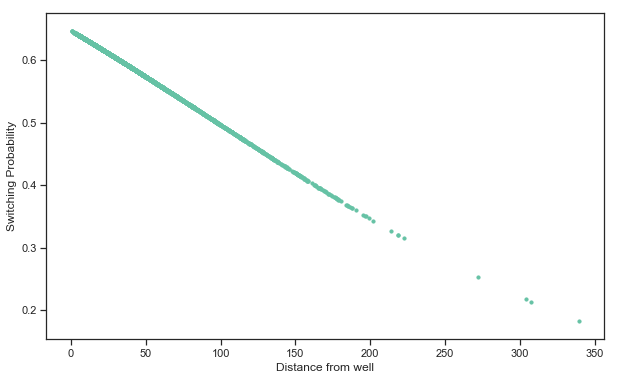

In [16]:
# plt.scatter(X_1[:,1],y)
plt.figure(figsize=(10,6))
plt.scatter(X_1[:,1], yprobability, s=10)
plt.xlabel('Distance from well')
plt.ylabel('Switching Probability')
plt.show()

#### 3. Rule-of-four to interpret features

In [17]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [18]:
df.head()

,switch,arsenic,dist,assoc,educ
1,1,2.36,16.826000,0,0
2,1,0.71,47.321999,0,0
3,0,2.07,20.966999,0,10
4,1,1.15,21.486000,0,12
5,1,1.10,40.874001,1,14


In [19]:
logreg = LogisticRegression()
logreg.fit(X, y)

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
# Getting coefficients of logistic regression
logreg.coef_

array([[ 0.46568445, -0.008963  , -0.12448164,  0.04232983]])

The Rule of Four states gives a method to interpret the impact of a feature on the probability of the logistic regression outcome. The upper bound is given by the derivative(w.r.t x1) of sigm(ß<sub>0</sub> + ß<sub>1</sub>x<sub>1</sub> + ß<sub>2</sub>x<sub>2</sub>)

= ß<sub>1</sub>e<sup>0</sup>/(1+e<sup>0</sup>)²

= ß(1)/(1+1)²

= ß/4 

Taking the logistic regression coefficients (not including the intercept) and dividing them by 4 gives an upper bound of the predictive difference in probability of the outcome y=1 per unit increase in x.

For the feature "Distance from well" where ß = -0.12 an approximation using the ß/4 rule is that a 1 unit increase in x results in about a -0.12/4 = -0.03, or 3% decrease in the probability of y=1.

<br>
So, for a 100m increase in "Distance from well", the change in probability of switching will be a 300% decrease.

#### 4. Arsenic and Dist feature - Coefficients

#### Taking Constant Term, Arsenic and Distance features

In [21]:
X=df.iloc[:,1:3].values

X_2=np.column_stack((np.ones(len(X)),X))

In [22]:
lr3 = LogisticRegression()
lr3.fit(X_2, y)
lr3.coef_

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.00186056,  0.45997859, -0.0089613 ]])

#### 5. Standardizing and comparing Arsenic and Dist

In [23]:
# We can either use StandarScaler or normalize manually

# scaler = StandardScaler(with_mean=True, with_std=True)
# scaler = scaler.fit(X_2)
# x=scaler.transform(X_2)
# x

X_3=X_2[:,1:]
mean_arsenic=np.mean(X_2[:,1])
std_arsenic=np.std(X_2[:,1])
mean_dist=np.mean(X_2[:,2])
std_dist=np.std(X_2[:,2])
std_dist

x1=[((X_3[i,0]-mean_arsenic)/std_arsenic) for i in range(0,len(X_3))]
x2=[((X_3[i,1]-mean_dist)/std_dist) for i in range(0,len(X_3))]
x=np.column_stack((np.ones(len(X)),x1,x2))
x

array([[ 1.        ,  0.63499567, -0.81892321],
       [ 1.        , -0.85524506, -0.02624912],
       [ 1.        ,  0.37307458, -0.71128737],
       ...,
       [ 1.        , -1.0358803 , -1.05592488],
       [ 1.        , -0.9184674 , -0.66255101],
       [ 1.        , -0.90040387, -0.71448445]])

In [24]:
lr4 = LogisticRegression()
lr4.fit(x, y)
lr4.coef_

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.16623202,  0.50888805, -0.34414403]])

Increase in the magnitude of coefficient for Distance is observed. It is a crucial factor and on normalizing it can be seen as increasing from -0.008 to -0.344. 

For the distance feature, one unit increase in the normalized distance will **decrease** the probability of switching by around 34/4 ~ **8.5%**
For Arsenic, a one unit increase in normalized arsenic will **increase** probability by 50.8/4 ~ **12.7%** 
<br><br><br>
Hence, Arsenic level is still a more impactful feature than Distance from Well.

#### 6. Best model with Cross-validation

In [51]:
X=df.iloc[:,1:].values
X

array([[ 2.36      , 16.82600021,  0.        ,  0.        ],
       [ 0.71      , 47.3219986 ,  0.        ,  0.        ],
       [ 2.07      , 20.96699905,  0.        , 10.        ],
       ...,
       [ 0.51      ,  7.70800018,  0.        ,  4.        ],
       [ 0.64      , 22.84199905,  0.        ,  3.        ],
       [ 0.66      , 20.84399986,  1.        ,  5.        ]])

In [52]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = scaler.fit(X)
X_norm=scaler.transform(X)

lr4 = LogisticRegression()
lr4.fit(X_norm, y)
lr4.coef_

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.51572495, -0.34391818, -0.06132579,  0.17016938]])

In [53]:
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_norm, y)
ypred=lr.predict(X_norm)
a=accuracy_score(y,ypred)
a

0.6165562913907284

In [54]:
print("Test Error:")
print(mean_squared_error(y,ypred))

Test Error:
0.3834437086092715


#### Due to large effect of Arsenic and Distance they can be combined into a single interaction term.

In [55]:
# Interaction Term added - Lesser Accuracy
x_int=X_norm[:,0]*X_norm[:,1]
X_cv=np.column_stack([x_int,X_norm[:,2:4]])
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_cv, y)
ypred=lr.predict(X_cv)
a=accuracy_score(y,ypred)
a

0.5721854304635762

#### Lesser accuracy with Interaction term, so using normalized X and cross-validating

In [60]:
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_norm, y)
cv_score=cross_validate(lr, X_norm, y, cv=5, scoring=('accuracy'))

In [61]:
cv_score['test_score'].mean()

0.603638237942065

In [64]:
print("Test Error:")
print(1-cv_score['test_score'].mean())

Test Error:
0.39636176205793505
